In [1]:
# https://www.kaggle.com/datasets/ignaciovinuales/battery-remaining-useful-life-rul

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import joblib
import os


plt.style.use('seaborn')
sns.set_palette("husl")

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


/tmp/ipykernel_4181162/914240871.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
battery_data = pd.read_csv(r'/home/romulo/Documentos/PDC_codes/Battery_RUL.csv')

The Hawaii Natural Energy Institute examined 14 NMC-LCO 18650 batteries with a nominal capacity of 2.8 Ah, which were cycled over 1000 times at 25°C with a CC-CV charge rate of C/2 rate and discharge rate of 1.5C.

From that source dataset, I created features that showcase the voltage and current behaviour over each cycle. Those features can be used to predict the remaining useful life (RUL) of the batteries. The dataset contains the summary of the 14 batteries.

Variables:

Cycle Index: number of cycle
F1: Discharge Time (s)
F2: Time at 4.15V (s)
F3: Time Constant Current (s)
F4: Decrement 3.6-3.4V (s)
F5: Max. Voltage Discharge (V)
F6: Min. Voltage Charge (V)
F7: Charging Time (s)
Total time (s)
RUL: target

In [4]:
display(battery_data.iloc[577])

Cycle_Index                   599.000
Discharge Time (s)           1545.880
Decrement 3.6-3.4V (s)        463.125
Max. Voltage Dischar. (V)       3.910
Min. Voltage Charg. (V)         3.744
Time at 4.15V (s)            2807.250
Time constant current (s)    3752.000
Charging time (s)            8415.620
RUL                           514.000
Name: 577, dtype: float64

An exploratory analysis of the Remaining Useful Life (RUL) data for batteries identified patterns that influence the performance of a predictive model. The dataset has 15,064 records, covering batteries with high RUL values (above 1000 cycles) to those at the end of life (RUL = 0). One issue is the imbalance in the distribution: many samples lie between 501–1000 (6,720 samples) and 101–500 cycles (5,420 samples), while only 140 samples have RUL near zero. This scarcity of end-of-life examples makes it difficult for the model to learn how to predict remaining life at advanced stages of battery degradation.

Feature distributions vary. Temporal metrics—such as Discharge Time, Time at 4.15V, Time constant current, and Charging time—exhibit skewed distributions, with a concentration of lower values and outliers. Voltage measurements appear more regular, with the maximum discharge voltage (Max. Voltage Dischar.) approximating a normal distribution around 3.9–4.0 V and the minimum charge voltage (Min. Voltage Charg.) displaying a bimodal pattern with peaks near 3.5 V and 3.8 V.

Correlations indicate that voltage-based variables are the main predictors of RUL. The maximum discharge voltage shows a positive correlation of about 0.78, while the minimum charge voltage has a negative correlation of -0.76. Cycle_Index has a correlation of -1.0 with RUL, but its usefulness can be limited if the exact cycle count is not available. Other variables, including the temporal metrics, have lower correlations—below 0.18—suggesting limited predictive value in their current form.

Further review revealed anomalous values for records with RUL equal to 0. Some of these contain Discharge Time readings exceeding 670,000 seconds, whereas in other RUL ranges the average is below 10,000 seconds. These anomalies point to potential measurement or recording issues and highlight the need for data-cleaning measures to avoid skewed model training.

Analysis of parameters across the battery’s life shows degradation patterns. The maximum discharge voltage decreases from about 4.0 V to 3.8 V, and the minimum charge voltage increases from around 3.4 V to 3.8 V. Temporal metrics remain stable on average but contain fluctuations and outliers near the end of life. Their skewed distributions suggest that transformations, possibly non-linear, might help reduce the effect of extreme values.

To improve predictions across the RUL range, including near end of life, several steps are recommended. First, handling outliers—through removal or correction—can help address anomalous measurements. Second, techniques such as SMOTE (Synthetic Minority Over-sampling Technique) can mitigate the imbalance and better represent low-RUL cases during training. Additional features derived from voltage measurements may also capture relationships not apparent in the raw data.

Another consideration is the training setup. A stratified approach, ensuring representation of all RUL intervals, can keep performance from degrading in ranges with fewer samples. Transformations of skewed metrics may also enhance their correlation with RUL or provide interpretability.

The voltage-based variables are valuable for RUL prediction. However, imbalance and anomalous records pose obstacles to reliable modeling. By cleaning data, rebalancing RUL ranges, generating new features, and using a stratified training strategy, the model can achieve better results, including in the range close to the end of life.

General Information of the Dataset:
--------------------------------------------------
Total number of samples: 15064
Number of features: 9

Description of the features:
--------------------------------------------------
Cycle_Index               : Número do ciclo
Discharge Time (s)        : F1 - Tempo de descarga
Decrement 3.6-3.4V (s)    : F2 - Tempo de decremento entre 3.6V e 3.4V
Max. Voltage Dischar. (V) : F3 - Voltagem máxima de descarga
Min. Voltage Charg. (V)   : F4 - Voltagem mínima de carga
Time at 4.15V (s)         : F5 - Tempo em 4.15V
Time constant current (s) : F6 - Tempo de corrente constante
Charging time (s)         : F7 - Tempo de carga
RUL                       : Target - Vida útil restante

Descriptive Statistics:
--------------------------------------------------
        Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
count  15064.000000        15064.000000            15064.000000   
mean     556.155005         4581.273960             1239.784672   
std 

/home/romulo/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/romulo/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/romulo/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/romulo/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

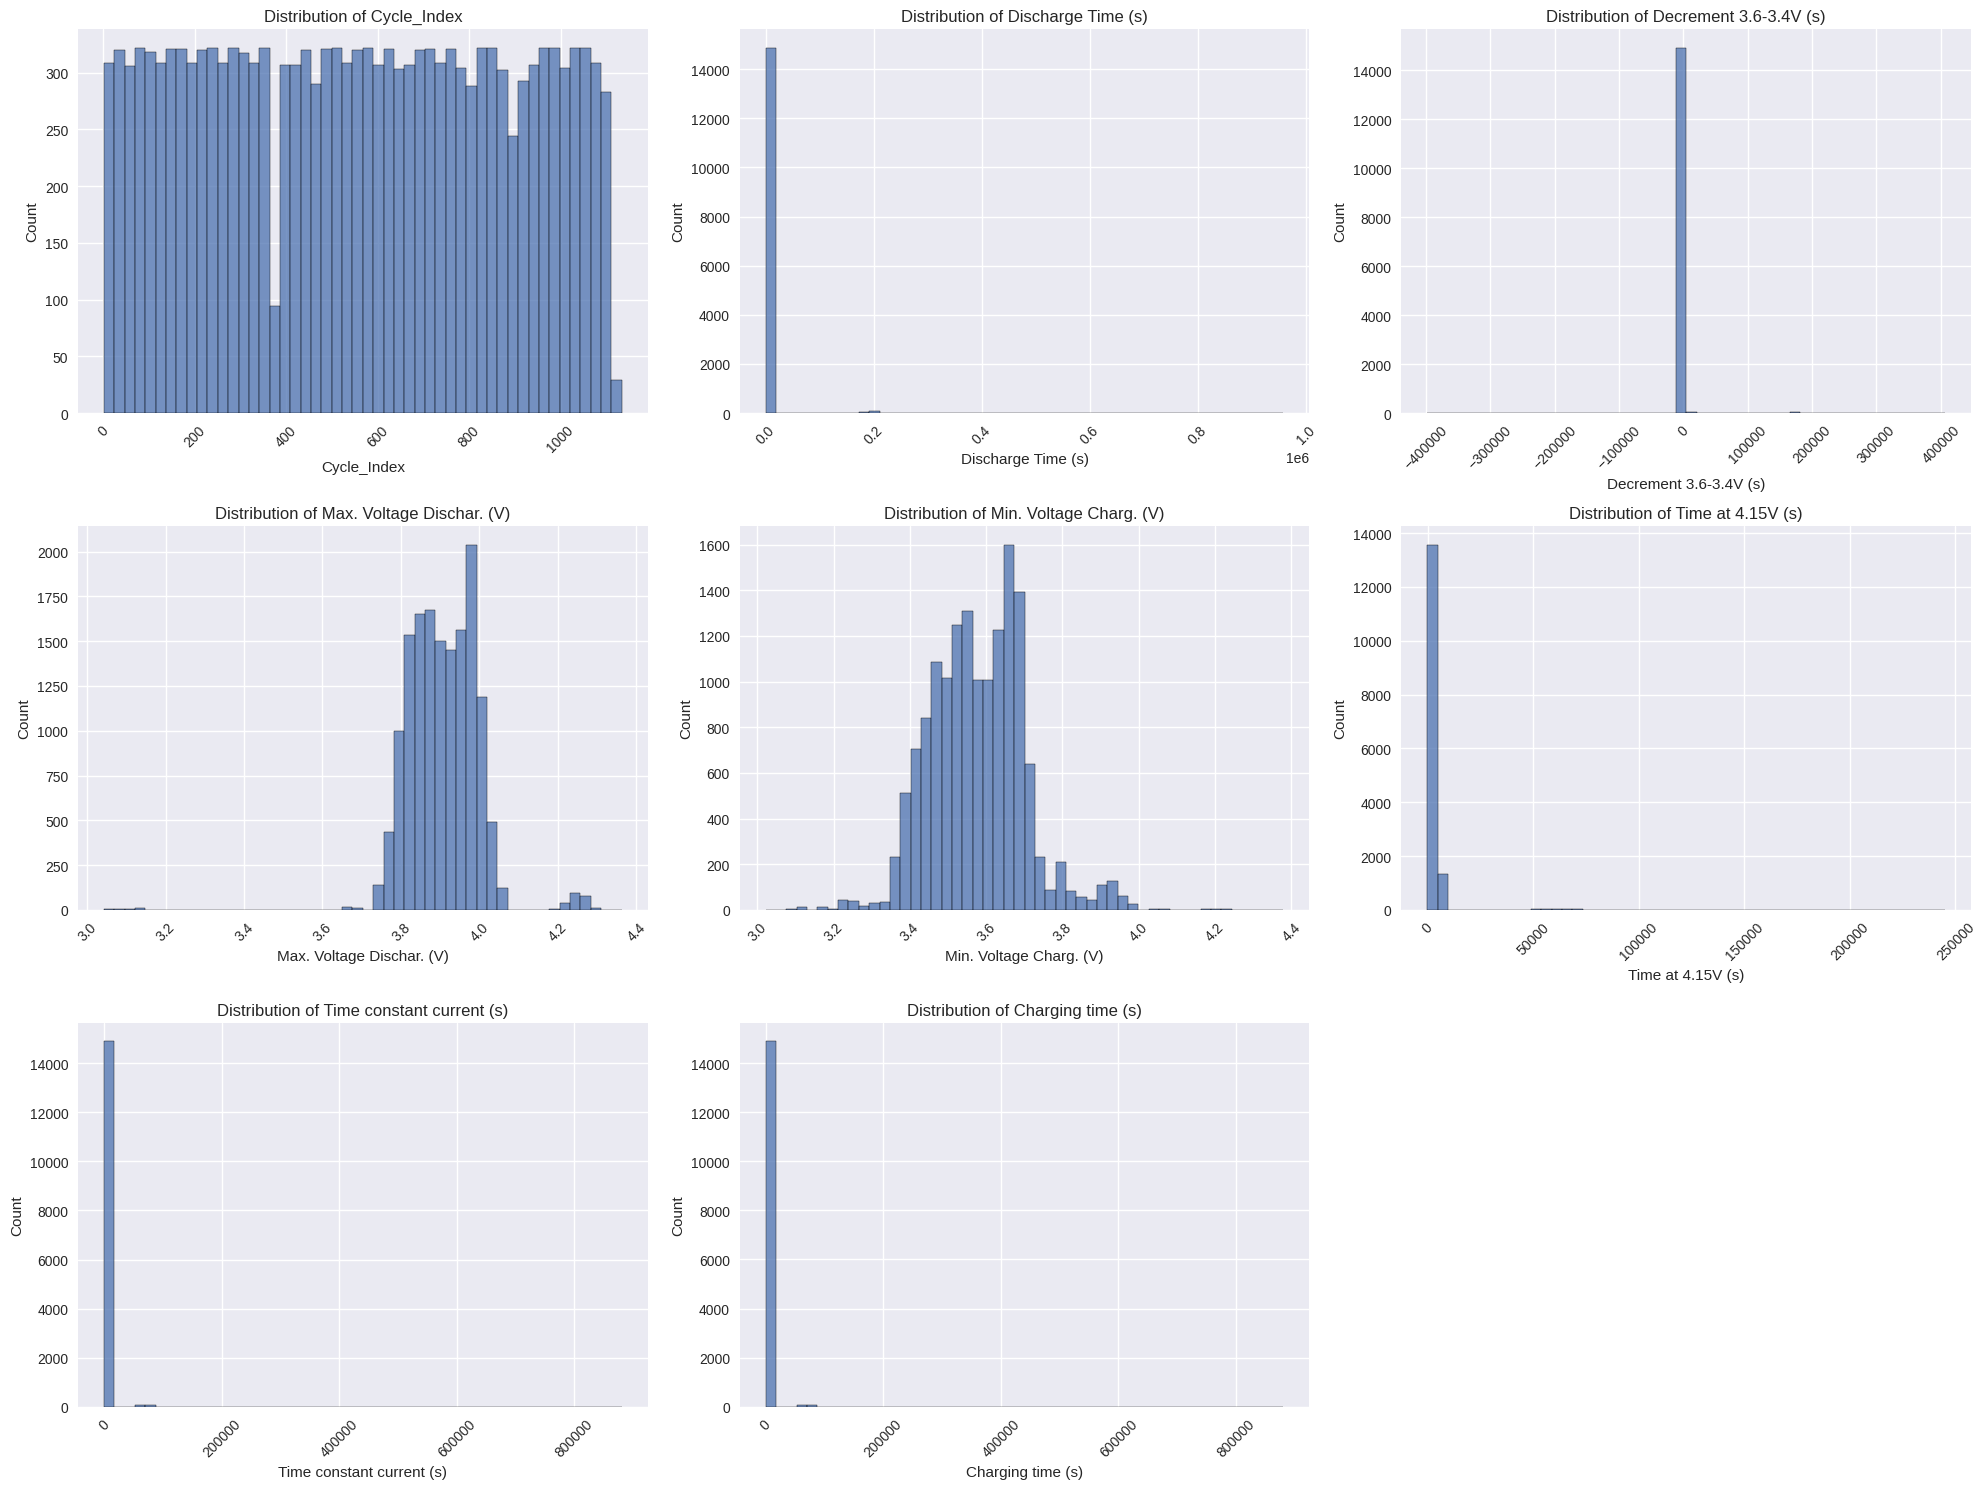

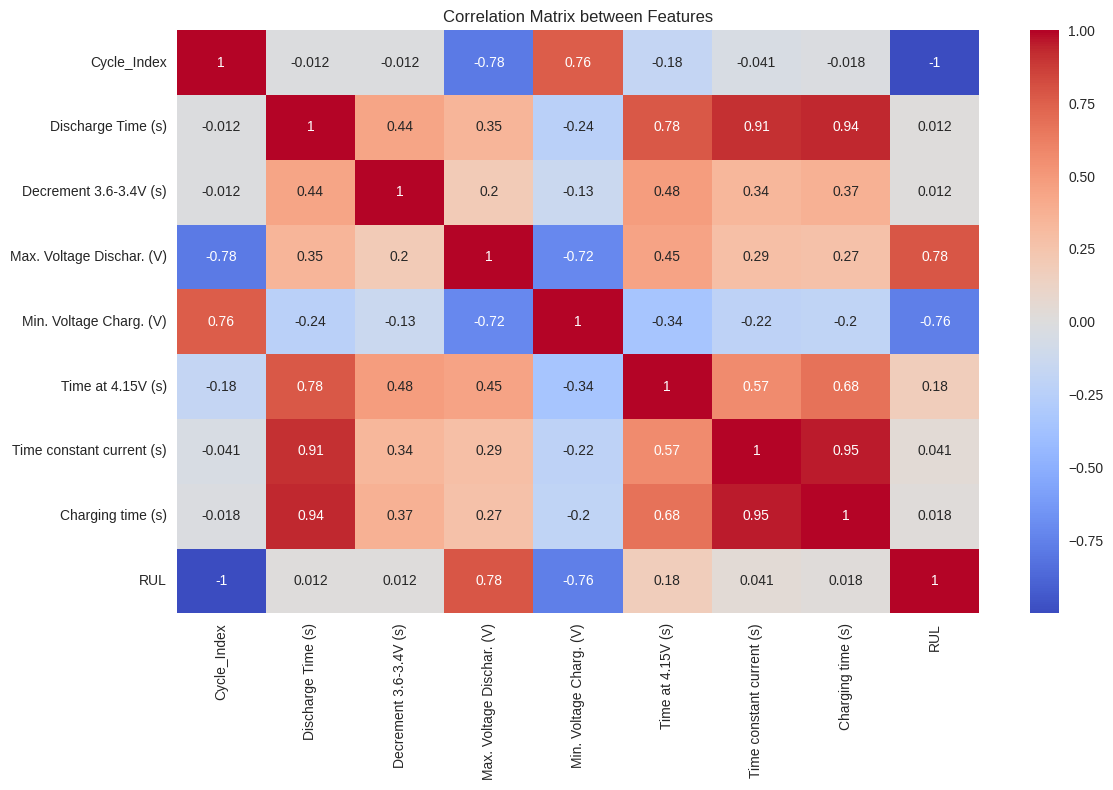

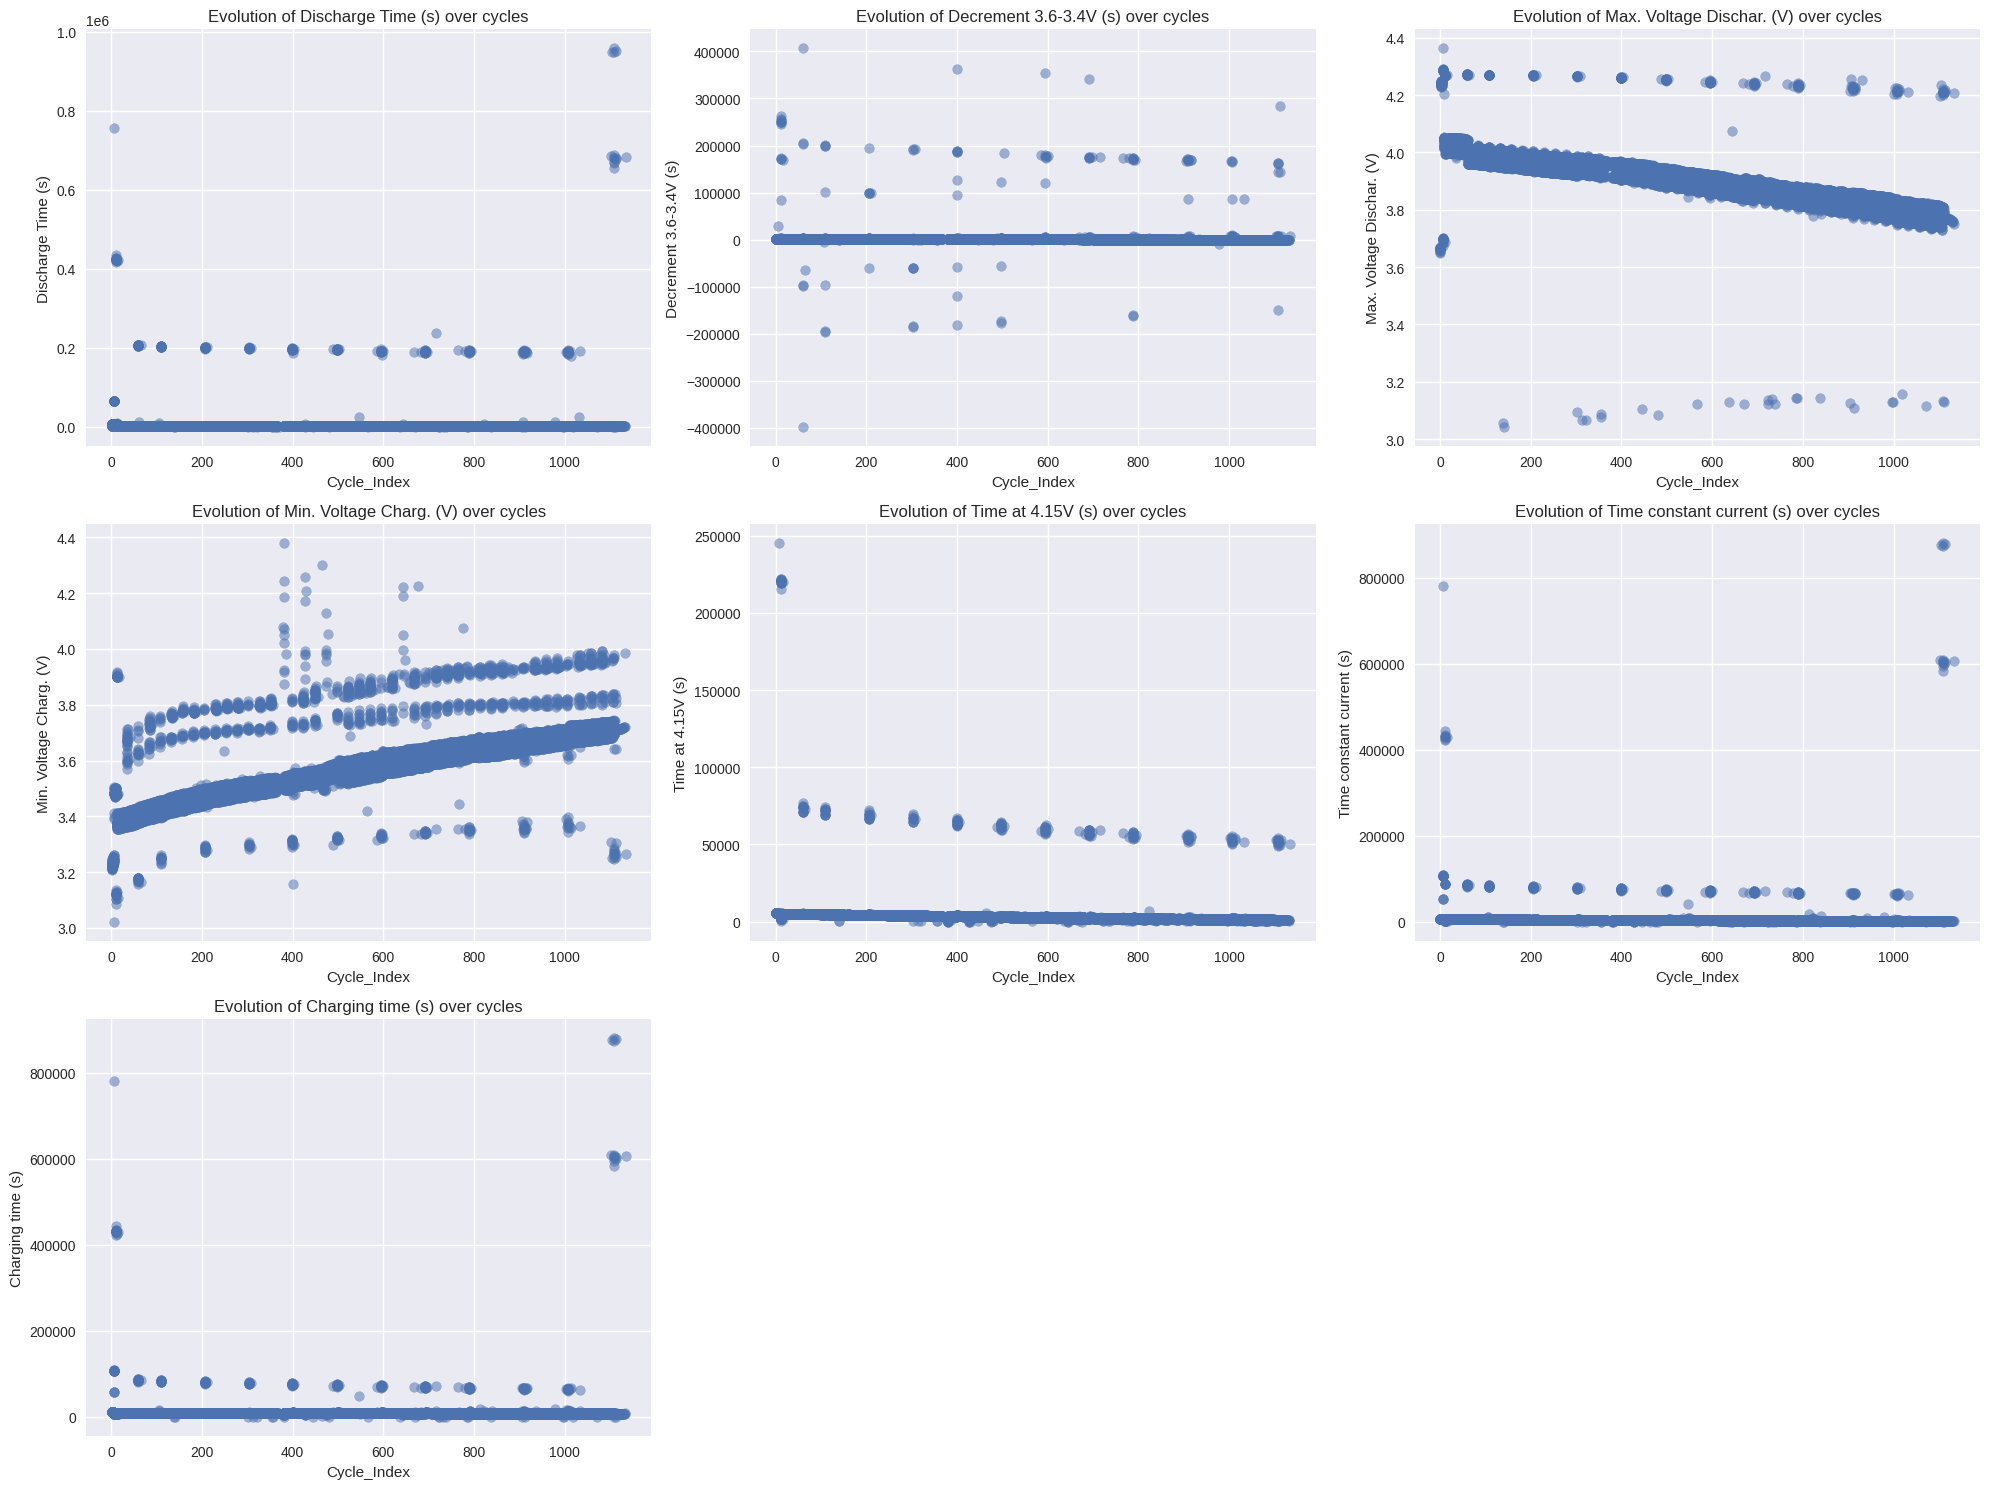

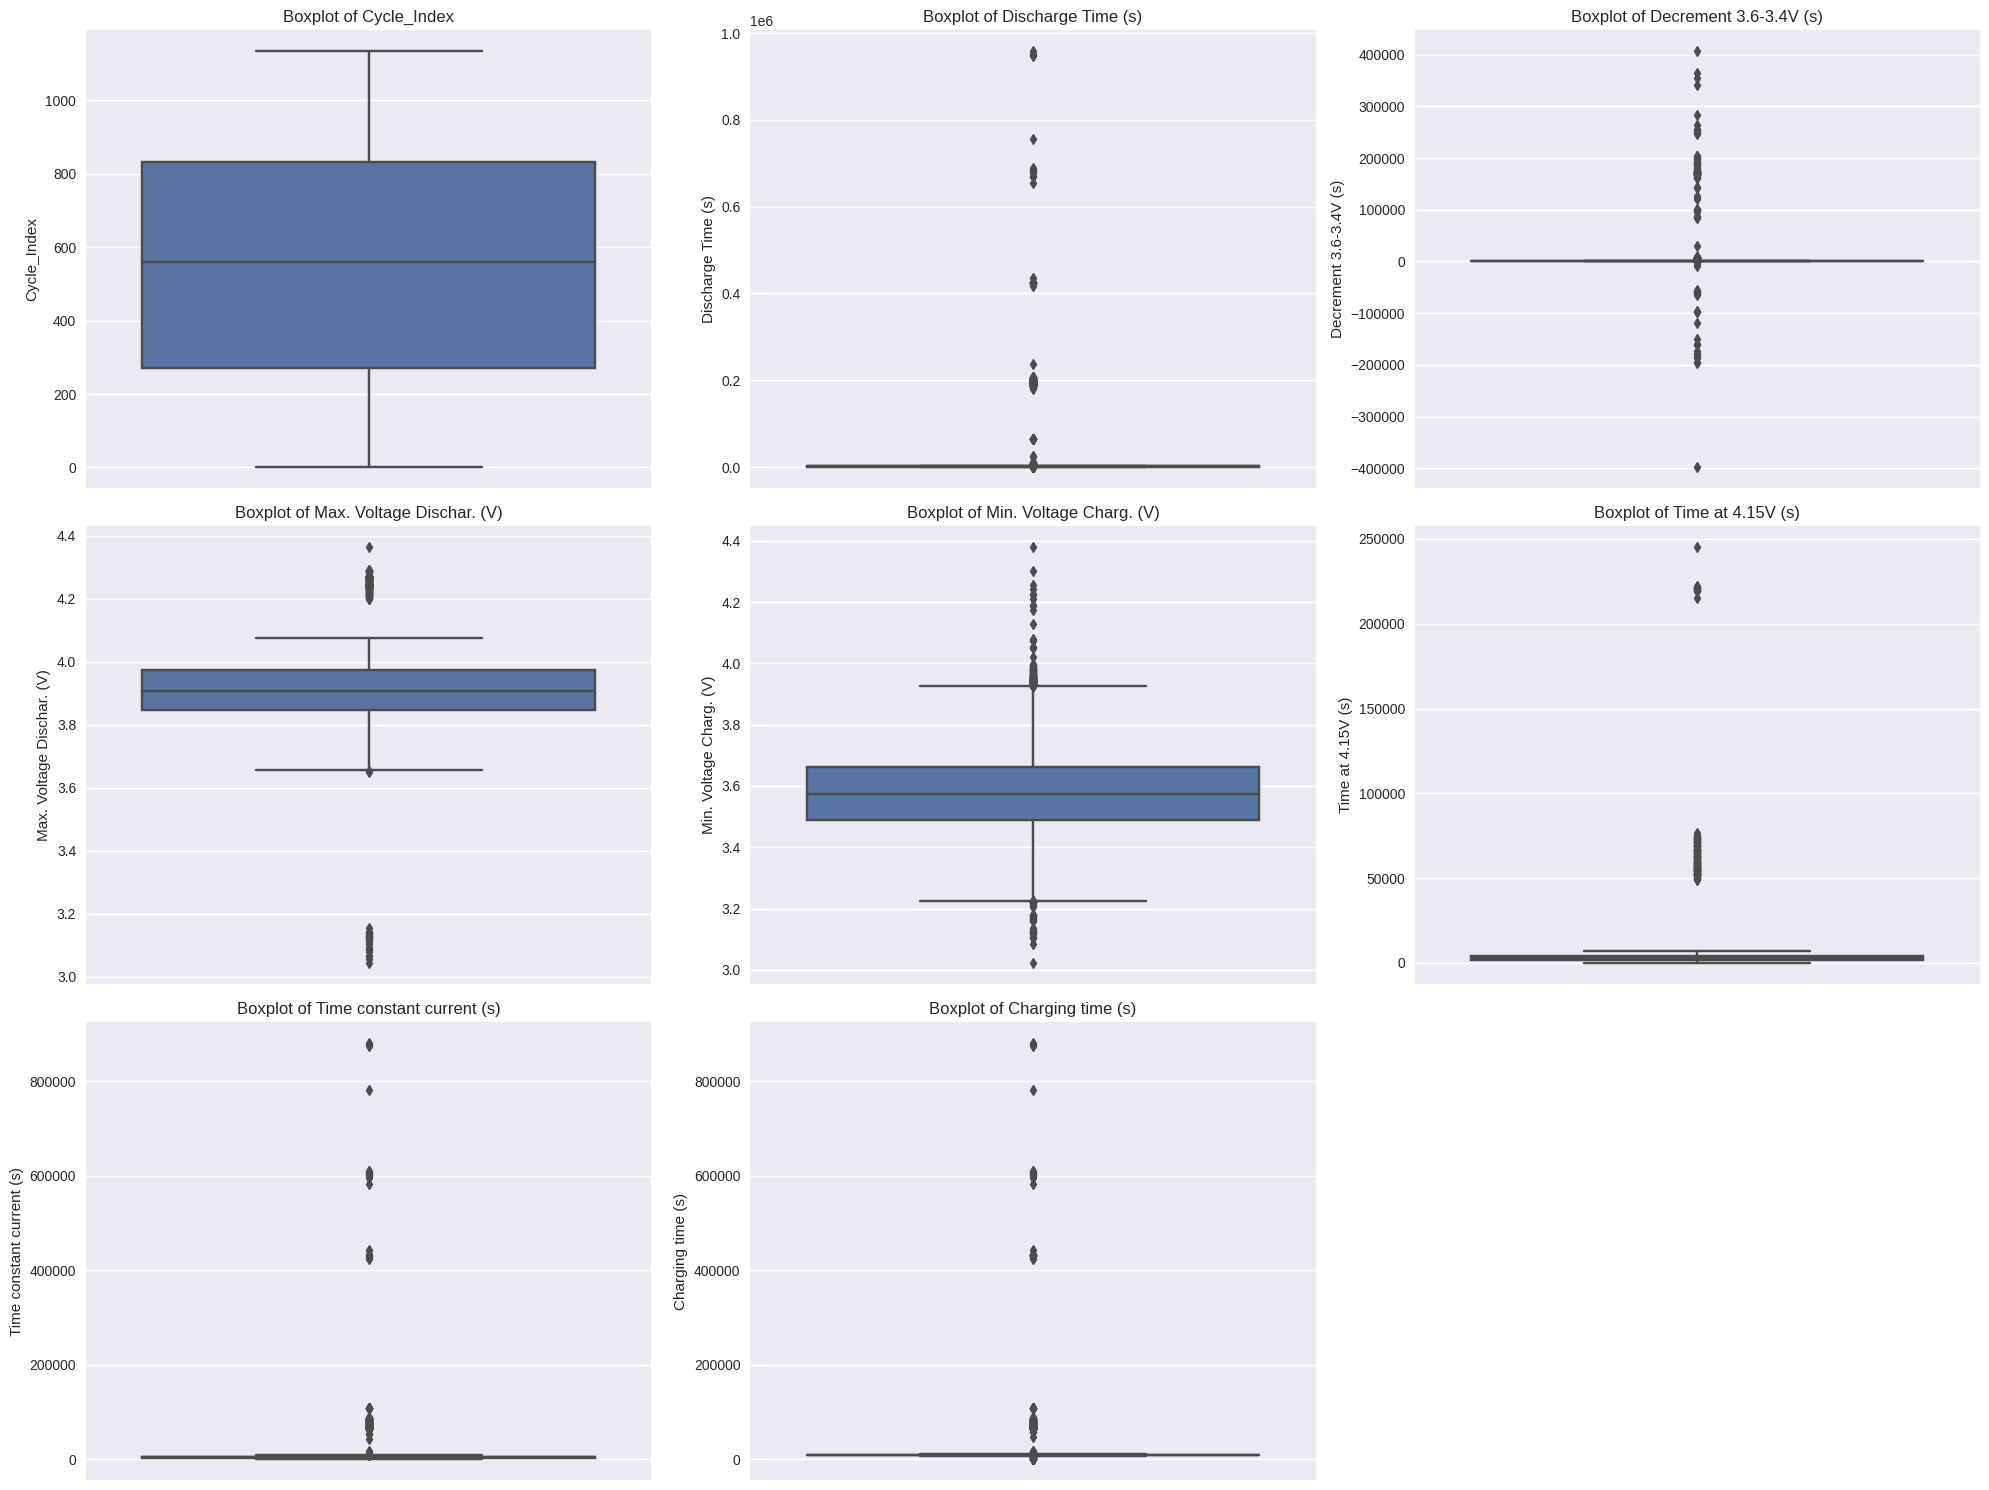


Statistics by RUL bin:
--------------------------------------------------
          Discharge Time (s)               Decrement 3.6-3.4V (s)  \
                        mean           std                   mean   
RUL_faixa                                                           
0-10              872.145286    125.372274             218.319807   
11-100            939.101747     87.152714             243.120661   
101-500          3043.328179  18509.718123            1193.247610   
501-1000         3853.463899  19960.289483            1002.798039   
>1000            9757.828776  50374.205323            2758.446782   

                        Max. Voltage Dischar. (V)            \
                    std                      mean       std   
RUL_faixa                                                     
0-10          37.715227                  3.769057  0.080340   
11-100        32.067071                  3.789984  0.034392   
101-500    12992.351159                  3.852961  0.0603

/tmp/ipykernel_4181162/1616936714.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rul_stats = battery_data.groupby('RUL_faixa')[battery_data.columns[1:-2]].agg(['mean', 'std'])


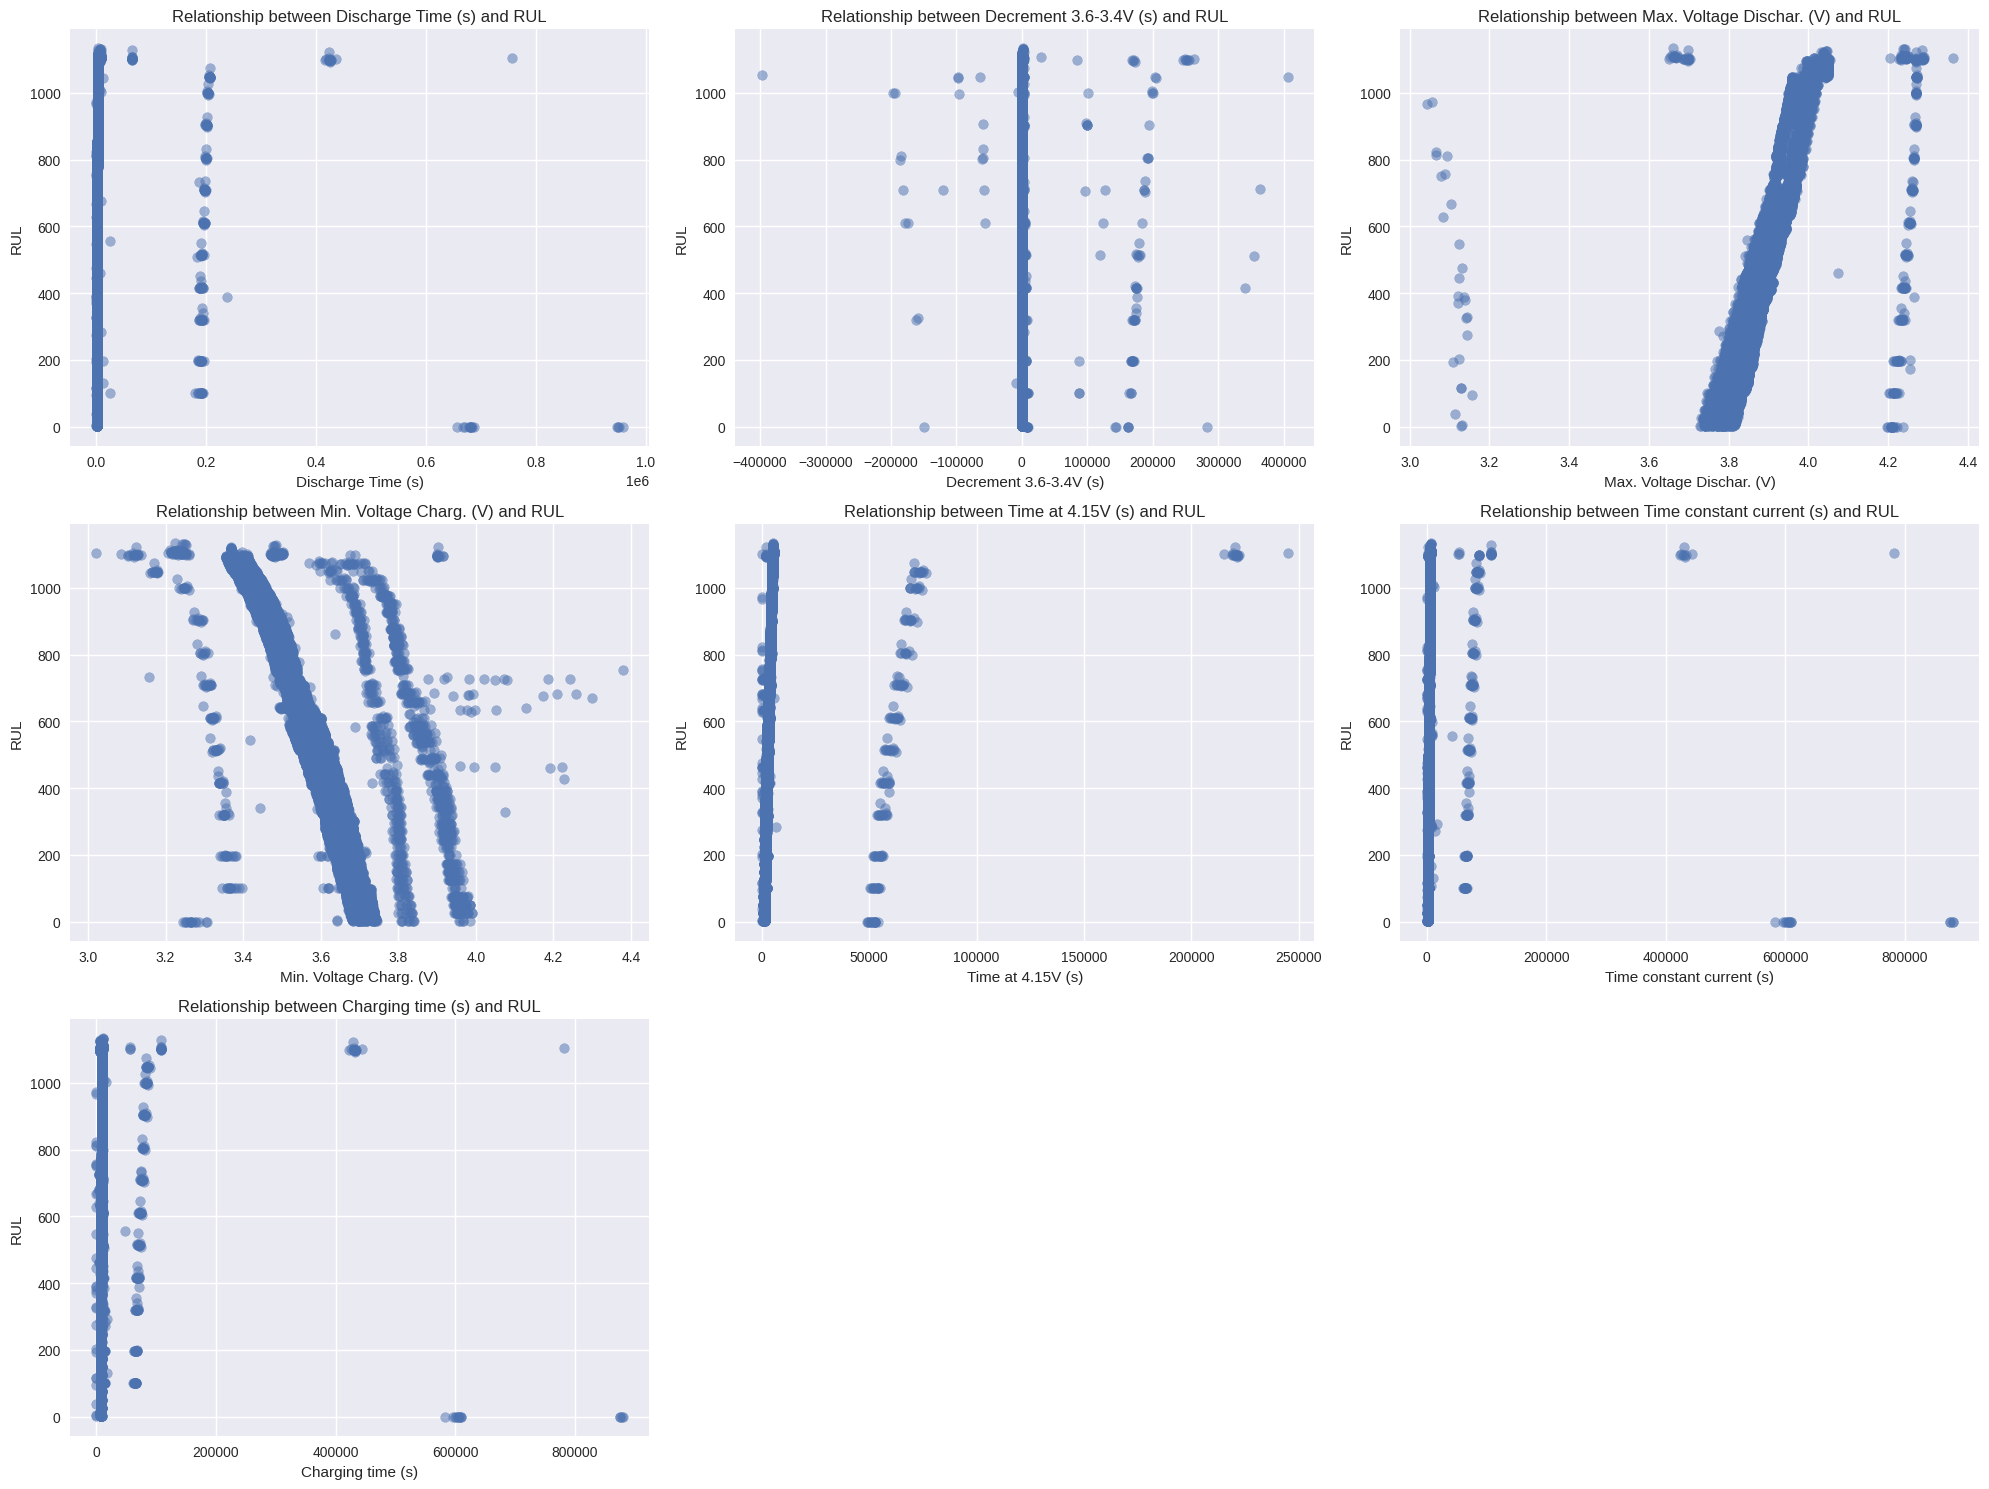


Correlations with RUL (sorted):
--------------------------------------------------
Cycle_Index                 -0.999756
Min. Voltage Charg. (V)     -0.759805
Discharge Time (s)           0.011957
Decrement 3.6-3.4V (s)       0.011998
Charging time (s)            0.018299
Time constant current (s)    0.040675
Time at 4.15V (s)            0.176514
Max. Voltage Dischar. (V)    0.782800
RUL                          1.000000
Name: RUL, dtype: float64


In [13]:


print("General Information of the Dataset:")
print("-" * 50)
print(f"Total number of samples: {len(battery_data)}")
print(f"Number of features: {len(battery_data.columns)}")
print("\nDescription of the features:")
print("-" * 50)
features_desc = {
    'Cycle_Index': 'Número do ciclo',
    'Discharge Time (s)': 'F1 - Tempo de descarga',
    'Decrement 3.6-3.4V (s)': 'F2 - Tempo de decremento entre 3.6V e 3.4V',
    'Max. Voltage Dischar. (V)': 'F3 - Voltagem máxima de descarga',
    'Min. Voltage Charg. (V)': 'F4 - Voltagem mínima de carga',
    'Time at 4.15V (s)': 'F5 - Tempo em 4.15V',
    'Time constant current (s)': 'F6 - Tempo de corrente constante',
    'Charging time (s)': 'F7 - Tempo de carga',
    'RUL': 'Target - Vida útil restante'
}
for feature, desc in features_desc.items():
    print(f"{feature:25} : {desc}")

print("\nDescriptive Statistics:")
print("-" * 50)
print(battery_data.describe())

plt.figure(figsize=(20, 15))
for i, feature in enumerate(battery_data.columns[:-1], 1):  # Excluindo RUL
    plt.subplot(3, 3, i)
    sns.histplot(data=battery_data, x=feature, bins=50)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
correlation_matrix = battery_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix between Features')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 15))
for i, feature in enumerate(battery_data.columns[1:-1], 1):  # Excluindo Cycle_Index e RUL
    plt.subplot(3, 3, i)
    plt.scatter(battery_data['Cycle_Index'], battery_data[feature], alpha=0.5)
    plt.title(f'Evolution of {feature} over cycles')
    plt.xlabel('Cycle_Index')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 15))
for i, feature in enumerate(battery_data.columns[:-1], 1):  # Excluindo RUL
    plt.subplot(3, 3, i)
    sns.boxplot(y=battery_data[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

bins = [0, 10, 100, 500, 1000, float('inf')]
labels = ['0-10', '11-100', '101-500', '501-1000', '>1000']
battery_data['RUL_faixa'] = pd.cut(battery_data['RUL'], bins=bins, labels=labels)

# Estatísticas por faixa de RUL
print("\nStatistics by RUL bin:")
print("-" * 50)
rul_stats = battery_data.groupby('RUL_faixa')[battery_data.columns[1:-2]].agg(['mean', 'std'])
print(rul_stats)

plt.figure(figsize=(20, 15))
for i, feature in enumerate(battery_data.columns[1:-2], 1):  # Excluindo Cycle_Index e RUL_faixa
    plt.subplot(3, 3, i)
    plt.scatter(battery_data[feature], battery_data['RUL'], alpha=0.5)
    plt.title(f'Relationship between {feature} and RUL')
    plt.xlabel(feature)
    plt.ylabel('RUL')
plt.tight_layout()
plt.show()

correlations = battery_data[battery_data.columns[:-1]].corr()['RUL'].sort_values()
print("\nCorrelations with RUL (sorted):")
print("-" * 50)
print(correlations)

/tmp/ipykernel_4181162/2660197138.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


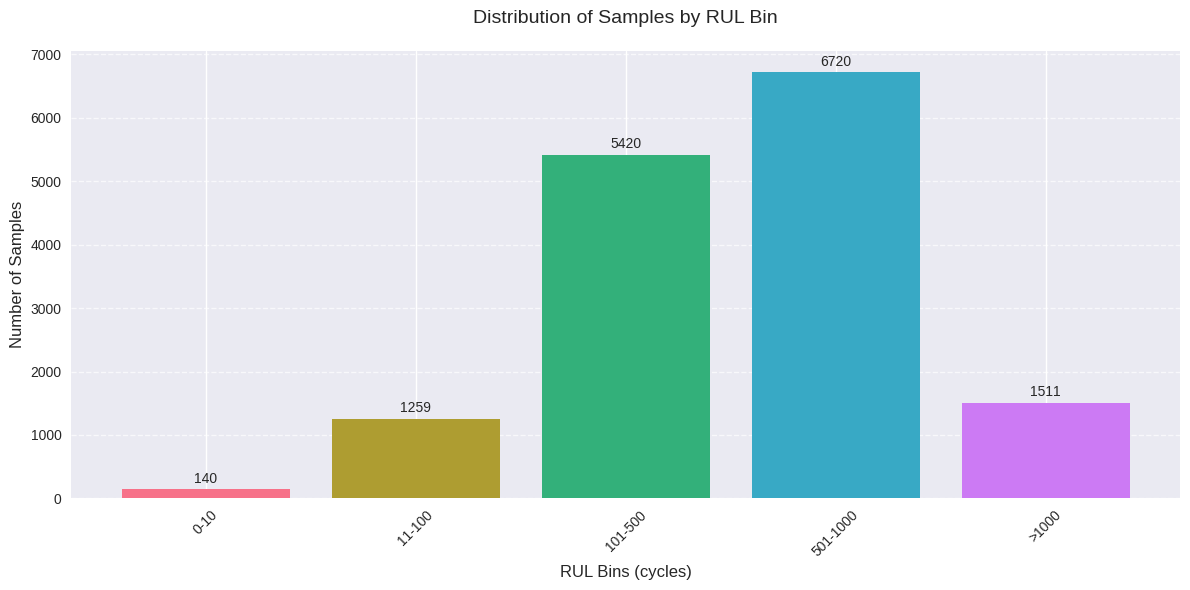


Statistics by RUL bin:
Bin 0-10    :   140 samples (  0.9%)
Bin 11-100  :  1259 samples (  8.4%)
Bin 101-500 :  5420 samples ( 36.0%)
Bin 501-1000:  6720 samples ( 44.6%)
Bin >1000   :  1511 samples ( 10.0%)


In [6]:

plt.style.use('seaborn')
plt.figure(figsize=(12, 6))

bins = [0, 10, 100, 500, 1000, float('inf')]
labels = ['0-10', '11-100', '101-500', '501-1000', '>1000']
battery_data['RUL_faixa'] = pd.cut(battery_data['RUL'], bins=bins, labels=labels)

rul_counts = battery_data['RUL_faixa'].value_counts().sort_index()

colors = sns.color_palette("husl", 5)
plt.bar(range(len(rul_counts)), rul_counts.values, color=colors)

plt.title('Distribution of Samples by RUL Bin', fontsize=14, pad=20)
plt.xlabel('RUL Bins (cycles)', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(range(len(labels)), labels, rotation=45)

for i, v in enumerate(rul_counts.values):
    plt.text(i, v + 100, str(v), ha='center', fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nStatistics by RUL bin:")
for faixa, count in rul_counts.items():
    percentage = (count/len(battery_data))*100
    print(f"Bin {faixa:8}: {count:5} samples ({percentage:5.1f}%)")

In [7]:


def clean_dataset(df):
    print("Original dataset size:", len(df))
    
    stats = df.describe()
    
    df_clean = df.copy()
    features = ['Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 
                'Time constant current (s)', 'Charging time (s)']
    
    for feature in features:
        Q1 = stats.loc['25%', feature]
        Q3 = stats.loc['75%', feature]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        

        df_clean = df_clean[
            (df_clean[feature] >= lower_bound) & 
            (df_clean[feature] <= upper_bound)
        ]
    
    print("Size after removing anomalies:", len(df_clean))
    return df_clean

def create_features(df):
    df_new = df.copy()
    
    df_new['voltage_range'] = df_new['Max. Voltage Dischar. (V)'] - df_new['Min. Voltage Charg. (V)']
    df_new['charging_efficiency'] = df_new['Charging time (s)'] / df_new['Discharge Time (s)']
    df_new['voltage_decay_rate'] = df_new['Decrement 3.6-3.4V (s)'] / df_new['Discharge Time (s)']
    df_new['charging_speed'] = df_new['Time constant current (s)'] / df_new['Charging time (s)']
    
    df_new = df_new.replace([np.inf, -np.inf], np.nan)
    df_new = df_new.dropna()
    
    return df_new

def balance_by_stratified_sampling(df):
    df['RUL_bin'] = pd.qcut(df['RUL'], q=10, labels=False)
    
    min_size = df.groupby('RUL_bin').size().min()
    max_size = df.groupby('RUL_bin').size().max()
    print("Size of the smallest class:", min_size)
    print("Size of the largest class:", max_size)
    
    balanced_samples = []
    for bin_label in df['RUL_bin'].unique():
        bin_data = df[df['RUL_bin'] == bin_label]
        balanced_samples.append(bin_data.sample(n=min_size, random_state=42))
    
    df_balanced = pd.concat(balanced_samples)
    df_balanced = df_balanced.drop('RUL_bin', axis=1)
    
    print("\nSize of the dataset after balancing:", len(df_balanced))
    return df_balanced

def prepare_data(df):
    features = ['Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Max. Voltage Dischar. (V)',
                'Min. Voltage Charg. (V)', 'Time at 4.15V (s)', 'Time constant current (s)',
                'Charging time (s)', 'voltage_range', 'charging_efficiency', 
                'voltage_decay_rate', 'charging_speed']
    
    X = df[features].values
    y = df['RUL'].values
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    return X_scaled, y_scaled, scaler_X, scaler_y

def process_dataset(df):
    print("Initializing dataset processing...")
    
    print("\nStep 1: Cleaning the data")
    df_clean = clean_dataset(df)
    
    print("\nStep 2: Creating new features")
    df_featured = create_features(df_clean)
    print("New features created:", 
          [col for col in df_featured.columns if col not in df_clean.columns])
    
    print("\nStep 3: Balancing the dataset")
    df_balanced = balance_by_stratified_sampling(df_featured)
    
    print("\nStep 4: Data preparation")
    X_scaled, y_scaled, scaler_X, scaler_y = prepare_data(df_balanced)
    
    print("\nStep 5: Train/test split")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

battery_data = pd.read_csv('/home/romulo/Documentos/PDC_codes/Battery_RUL.csv')
X_train, X_test, y_train, y_test, scaler_X, scaler_y = process_dataset(battery_data)

df_processed = create_features(clean_dataset(battery_data))
correlations = df_processed.corr()['RUL'].sort_values()
print("\nCorrelations with RUL (including new features):")
print(correlations)

np.save('X_train_processed.npy', X_train)
np.save('X_test_processed.npy', X_test)
np.save('y_train_processed.npy', y_train)
np.save('y_test_processed.npy', y_test)

Initializing dataset processing...

Step 1: Cleaning the data
Original dataset size: 15064
Size after removing anomalies: 14615

Step 2: Creating new features
New features created: ['voltage_range', 'charging_efficiency', 'voltage_decay_rate', 'charging_speed']

Step 3: Balancing the dataset
Size of the smallest class: 1452
Size of the largest class: 1473

Size of the dataset after balancing: 14520

Step 4: Data preparation

Step 5: Train/test split
Original dataset size: 15064
Size after removing anomalies: 14615

Correlations with RUL (including new features):
Cycle_Index                 -0.999752
charging_efficiency         -0.886996
Min. Voltage Charg. (V)     -0.806098
voltage_decay_rate           0.756862
Charging time (s)            0.897690
voltage_range                0.908241
Max. Voltage Dischar. (V)    0.957817
Decrement 3.6-3.4V (s)       0.964596
charging_speed               0.973543
Time constant current (s)    0.982676
Time at 4.15V (s)            0.985559
Discharge Tim

Modelo corrigido 

In [8]:
df_processed.iloc[554]

Cycle_Index                   599.000000
Discharge Time (s)           1545.880000
Decrement 3.6-3.4V (s)        463.125000
Max. Voltage Dischar. (V)       3.910000
Min. Voltage Charg. (V)         3.744000
Time at 4.15V (s)            2807.250000
Time constant current (s)    3752.000000
Charging time (s)            8415.620000
RUL                           514.000000
voltage_range                   0.166000
charging_efficiency             5.443903
voltage_decay_rate              0.299587
charging_speed                  0.445838
Name: 577, dtype: float64

Initializing dataset processing...

Step 1: Cleaning the data
Original size of the dataset: 15064
Size after removing anomalies: 14615

Step 2: Creating new features
Novas features criadas: ['voltage_decay_rate', 'voltage_range', 'charging_efficiency', 'charging_speed']

Step 3: Balancing the dataset

Size of the dataset after balancing: 14520

Step 4: Data preparation (scaling)

Step 5: Train/test split
Original size of the dataset: 15064
Size after removing anomalies: 14615

Correlações com RUL (incluindo novas features):
Cycle_Index                 -0.999752
charging_efficiency         -0.886996
Min. Voltage Charg. (V)     -0.806098
voltage_decay_rate           0.756862
Charging time (s)            0.897690
voltage_range                0.908241
Max. Voltage Dischar. (V)    0.957817
Decrement 3.6-3.4V (s)       0.964596
charging_speed               0.973543
Time constant current (s)    0.982676
Time at 4.15V (s)            0.985559
Discharge Time (s)           0.986558
RUL           

/home/romulo/.local/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/50 | Train Loss=0.0259 | Val Loss=0.0053 | LR=0.000167
Epoch 2/50 | Train Loss=0.0064 | Val Loss=0.0025 | LR=0.000333
Epoch 3/50 | Train Loss=0.0057 | Val Loss=0.0024 | LR=0.000500
Epoch 4/50 | Train Loss=0.0045 | Val Loss=0.0050 | LR=0.000500
Epoch 5/50 | Train Loss=0.0043 | Val Loss=0.0033 | LR=0.000500
Epoch 6/50 | Train Loss=0.0038 | Val Loss=0.0015 | LR=0.000500
Epoch 7/50 | Train Loss=0.0036 | Val Loss=0.0015 | LR=0.000500
Epoch 8/50 | Train Loss=0.0031 | Val Loss=0.0023 | LR=0.000500
Epoch 9/50 | Train Loss=0.0031 | Val Loss=0.0032 | LR=0.000500
Epoch 10/50 | Train Loss=0.0028 | Val Loss=0.0015 | LR=0.000500
Epoch 11/50 | Train Loss=0.0027 | Val Loss=0.0017 | LR=0.000500
Epoch 12/50 | Train Loss=0.0025 | Val Loss=0.0031 | LR=0.000500
Epoch 13/50 | Train Loss=0.0026 | Val Loss=0.0014 | LR=0.000500
Epoch 14/50 | Train Loss=0.0023 | Val Loss=0.0035 | LR=0.000500
Epoch 15/50 | Train Loss=0.0024 | Val Loss=0.0024 | LR=0.000500
Epoch 16/50 | Train Loss=0.0024 | Val Loss=0.0016

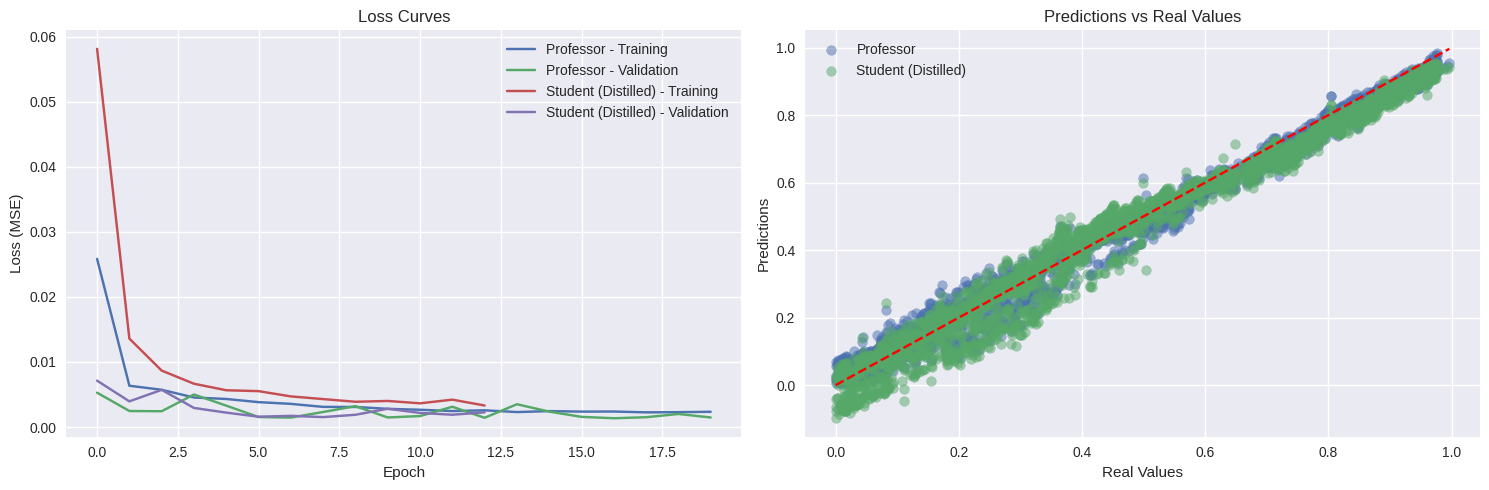


Sizes (in RAM, approximate):
Teacher: 584.51 KB
Student(Dist): 52.80 KB
Compression Ratio: 11.07x

Sizes (in disk, in .pth):
Teacher: 592.78 KB
Student(Dist): 57.51 KB

Size of the quantized Student model (in disk): 26.67 KB


In [9]:
def clean_dataset(df):
    print("Original size of the dataset:", len(df))
    
    stats = df.describe()
    
    # Define limits of IQR for some columns
    features = [
        'Discharge Time (s)', 
        'Decrement 3.6-3.4V (s)', 
        'Time constant current (s)', 
        'Charging time (s)'
    ]
    
    df_clean = df.copy()
    for feature in features:
        Q1 = stats.loc['25%', feature]
        Q3 = stats.loc['75%', feature]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_clean = df_clean[
            (df_clean[feature] >= lower_bound) &
            (df_clean[feature] <= upper_bound)
        ]
    
    print("Size after removing anomalies:", len(df_clean))
    return df_clean

def create_features(df):
    df_new = df.copy()
    
    # Creating new features
    df_new['voltage_range'] = df_new['Max. Voltage Dischar. (V)'] - df_new['Min. Voltage Charg. (V)']
    df_new['charging_efficiency'] = df_new['Charging time (s)'] / df_new['Discharge Time (s)']
    df_new['voltage_decay_rate'] = df_new['Decrement 3.6-3.4V (s)'] / df_new['Discharge Time (s)']
    df_new['charging_speed'] = df_new['Time constant current (s)'] / df_new['Charging time (s)']
    
    # Treat infinite and NaN
    df_new = df_new.replace([np.inf, -np.inf], np.nan)
    df_new = df_new.dropna()
    
    return df_new

def balance_by_stratified_sampling(df):
    df = df.copy()
    df['RUL_bin'] = pd.qcut(df['RUL'], q=10, labels=False)
    
    # Find the size of the smallest class
    min_size = df.groupby('RUL_bin').size().min()
    
    # Balanced sampling
    balanced_samples = []
    for bin_label in df['RUL_bin'].unique():
        bin_data = df[df['RUL_bin'] == bin_label]
        balanced_samples.append(bin_data.sample(n=min_size, random_state=42))
    
    df_balanced = pd.concat(balanced_samples).drop('RUL_bin', axis=1)
    df_balanced = df_balanced.sample(frac=1.0, random_state=42).reset_index(drop=True)
    
    print("\nSize of the dataset after balancing:", len(df_balanced))
    return df_balanced

def prepare_data(df):
    features = [
        'Discharge Time (s)', 
        'Decrement 3.6-3.4V (s)', 
        'Max. Voltage Dischar. (V)',
        'Min. Voltage Charg. (V)', 
        'Time at 4.15V (s)', 
        'Time constant current (s)',
        'Charging time (s)', 
        'voltage_range', 
        'charging_efficiency',
        'voltage_decay_rate', 
        'charging_speed'
    ]
    
    X = df[features].values
    y = df['RUL'].values
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    return X_scaled, y_scaled, scaler_X, scaler_y

def process_dataset(df):
    print("Initializing dataset processing...")
    
    print("\nStep 1: Cleaning the data")
    df_clean = clean_dataset(df)
    
    print("\nStep 2: Creating new features")
    df_featured = create_features(df_clean)
    new_cols = set(df_featured.columns) - set(df_clean.columns)
    print("Novas features criadas:", list(new_cols))
    
    print("\nStep 3: Balancing the dataset")
    df_balanced = balance_by_stratified_sampling(df_featured)
    
    print("\nStep 4: Data preparation (scaling)")
    X_scaled, y_scaled, scaler_X, scaler_y = prepare_data(df_balanced)
    
    print("\nStep 5: Train/test split")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y


class TeacherModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(TeacherModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, 
                            batch_first=True, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size*2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(hidden_size*2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        # x: (batch_size, input_size)
        # LSTM espera (batch_size, seq_len, input_size). Vamos fingir seq_len=1
        x = x.unsqueeze(1)  # (batch_size, 1, input_size)
        
        lstm_out, _ = self.lstm(x)  # (batch_size, 1, 2*hidden_size)
        lstm_out = lstm_out[:, -1, :]  # (batch_size, 2*hidden_size)
        
        x = self.batch_norm(lstm_out)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

class StudentModel(nn.Module):
    def __init__(self, input_size, hidden_size=48):
        super(StudentModel, self).__init__()
        self.feature_weights = nn.Parameter(torch.ones(input_size))
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        # x: (batch_size, input_size)
        # Ajuste por feature_weights
        x = x * self.feature_weights  
        
        # LSTM espera (batch_size, seq_len, input_size)
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        
        # Pega a última saída do LSTM
        lstm_out = lstm_out[:, -1, :]
        
        x = self.batch_norm(lstm_out)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.output(x)
        return x

class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            if self.restore_best_weights:
                self.best_weights = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            if self.restore_best_weights:
                self.best_weights = model.state_dict()
            self.counter = 0
            
    def restore(self, model):
        if self.restore_best_weights and self.best_weights is not None:
            model.load_state_dict(self.best_weights)

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            predictions.extend(outputs.numpy().flatten())
            targets.extend(target.numpy().flatten())
    return total_loss / len(dataloader), predictions, targets

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs,
                scheduler=None, early_stopping=None, warmup_epochs=3):
    """
    Training "standard", used here for the Professor.
    """
    train_losses = []
    val_losses = []
    initial_lr = optimizer.param_groups[0]['lr']
    
    for epoch in range(epochs):
        # Learning rate warmup
        if epoch < warmup_epochs:
            lr = initial_lr * (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss, _, _ = evaluate_model(model, val_loader, criterion)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if scheduler is not None and epoch >= warmup_epochs:
            scheduler.step(val_loss)
            
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | "
              f"LR={optimizer.param_groups[0]['lr']:.6f}")
        
        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered!")
                early_stopping.restore(model)
                break
                
    return (train_losses, val_losses)

def train_student_with_distillation(student, teacher, train_loader, val_loader, 
                                    criterion, alpha, optimizer, epochs,
                                    scheduler=None, early_stopping=None, warmup_epochs=3):
    """
    Training of the Student with distillation from the Professor:
    final_loss = alpha*MSE(Student, Label) + (1-alpha)*MSE(Student, Professor)
    """
    train_losses = []
    val_losses = []
    initial_lr = optimizer.param_groups[0]['lr']

    teacher.eval()
    
    for epoch in range(epochs):
        # Learning rate warmup
        if epoch < warmup_epochs:
            lr = initial_lr * (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        student.train()
        train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            with torch.no_grad():
                teacher_pred = teacher(inputs)
            
            student_pred = student(inputs)
            
            loss_supervised = criterion(student_pred, targets)
            loss_distill = criterion(student_pred, teacher_pred)
            
            loss = alpha * loss_supervised + (1 - alpha) * loss_distill
            
            loss.backward()
            nn.utils.clip_grad_norm_(student.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss, _, _ = evaluate_model(student, val_loader, criterion)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if scheduler is not None and epoch >= warmup_epochs:
            scheduler.step(val_loss)
            
        print(f"[Distillation] Epoch {epoch+1}/{epochs} | "
              f"Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | "
              f"LR={optimizer.param_groups[0]['lr']:.6f}")
        
        if early_stopping is not None:
            early_stopping(val_loss, student)
            if early_stopping.early_stop:
                print("Early stopping triggered!")
                early_stopping.restore(student)
                break
                
    return (train_losses, val_losses)


battery_data = pd.read_csv('/home/romulo/Documentos/PDC_codes/Battery_RUL.csv')

X_train, X_test, y_train, y_test, scaler_X, scaler_y = process_dataset(battery_data)

joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

df_tmp = create_features(clean_dataset(battery_data))
correlations = df_tmp.corr()['RUL'].sort_values()
print("\nCorrelações com RUL (incluindo novas features):")
print(correlations)

np.save('X_train_processed.npy', X_train)
np.save('X_test_processed.npy', X_test)
np.save('y_train_processed.npy', y_train)
np.save('y_test_processed.npy', y_test)



X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



input_size = X_train.shape[1]
criterion = nn.MSELoss()

teacher = TeacherModel(input_size)
teacher_optimizer = optim.Adam(teacher.parameters(), lr=0.0005)
teacher_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    teacher_optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)
early_stopping_teacher = EarlyStopping(patience=7, restore_best_weights=True)

print("\nTraining the Professor model...\n")
teacher_losses = train_model(
    model=teacher,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=teacher_optimizer,
    epochs=50,
    scheduler=teacher_scheduler,
    early_stopping=early_stopping_teacher,
    warmup_epochs=3
)



student = StudentModel(input_size)
student_optimizer = optim.Adam(student.parameters(), lr=0.0005)
student_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    student_optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)
early_stopping_student = EarlyStopping(patience=7, restore_best_weights=True)

alpha = 0.7  # Weight of the supervised loss vs. distillation loss

print(f"\nTraining the Student model with distillation (alpha={alpha})...\n")
student_losses = train_student_with_distillation(
    student=student,
    teacher=teacher,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    alpha=alpha,
    optimizer=student_optimizer,
    epochs=50,
    scheduler=student_scheduler,
    early_stopping=early_stopping_student,
    warmup_epochs=3
)


print("\nEvaluating models...")
teacher_loss, teacher_pred, teacher_true = evaluate_model(teacher, test_loader, criterion)
student_loss, student_pred, student_true = evaluate_model(student, test_loader, criterion)

print(f"Final loss of the Professor: {teacher_loss:.4f}")
print(f"Final loss of the Student (Distilled): {student_loss:.4f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(teacher_losses[0], label='Professor - Training')
plt.plot(teacher_losses[1], label='Professor - Validation')
plt.plot(student_losses[0], label='Student (Distilled) - Training')
plt.plot(student_losses[1], label='Student (Distilled) - Validation')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(teacher_true, teacher_pred, alpha=0.5, label='Professor')
plt.scatter(student_true, student_pred, alpha=0.5, label='Student (Distilled)')
min_val = min(teacher_true + student_true)
max_val = max(teacher_true + student_true)
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Predictions vs Real Values')
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.legend()

plt.tight_layout()
plt.show()


def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_kb = (param_size + buffer_size) / 1024
    return size_kb

def get_model_disk_size(model, path="temp.pth"):
    torch.save(model.state_dict(), path)
    size_kb = os.path.getsize(path) / 1024
    os.remove(path)
    return size_kb

teacher_size = get_model_size(teacher)
student_size = get_model_size(student)
print("\nSizes (in RAM, approximate):")
print(f"Teacher: {teacher_size:.2f} KB")
print(f"Student(Dist): {student_size:.2f} KB")
print(f"Compression Ratio: {teacher_size / student_size:.2f}x")

teacher_disk = get_model_disk_size(teacher, "teacher_temp.pth")
student_disk = get_model_disk_size(student, "student_temp.pth")
print("\nSizes (in disk, in .pth):")
print(f"Teacher: {teacher_disk:.2f} KB")
print(f"Student(Dist): {student_disk:.2f} KB")

def quantize_student_model(student_model, data_loader):
    """
    Example of static post-training quantization.
    In LSTMs, it usually doesn't work well without additional modifications.
    Follows a simple example of quantizing the linear layers.
    """
    model_to_quant = StudentModel(input_size)
    model_to_quant.load_state_dict(student_model.state_dict())
    model_to_quant.eval()

    # Define quantization configuration (ONLY for linear layers)
    model_to_quant.qconfig = torch.quantization.default_qconfig
    
    # Prepare (inplace=False returns another model)
    model_prepared = torch.quantization.prepare(model_to_quant, inplace=False)
    
    # Calibration loop
    with torch.no_grad():
        for inputs, _ in data_loader:
            model_prepared(inputs)
    
    # Convert to quantized model
    model_quantized = torch.quantization.convert(model_prepared, inplace=False)
    
    return model_quantized

student_quantized = quantize_student_model(student, train_loader)
torch.save(student_quantized.state_dict(), "student_quantized.pth")

quant_disk_size = get_model_disk_size(student_quantized, "quantized_temp.pth")
print(f"\nSize of the quantized Student model (in disk): {quant_disk_size:.2f} KB")


In [10]:
def process_new_data_for_inference(df_new, scaler_X):
    """
    Applies the same cleaning and feature engineering pipeline,
    but does not balance and does not refit the scaler.
    
    Returns: X_infer (scaled numpy array)
    """  
    # df_clean = clean_dataset(df_new)
    
    df_featured = create_features(df_new)
    # df_featured = create_features(df_clean)
    
    features = [
        'Discharge Time (s)', 
        'Decrement 3.6-3.4V (s)', 
        'Max. Voltage Dischar. (V)',
        'Min. Voltage Charg. (V)', 
        'Time at 4.15V (s)', 
        'Time constant current (s)',
        'Charging time (s)', 
        'voltage_range', 
        'charging_efficiency', 
        'voltage_decay_rate', 
        'charging_speed'
    ]
    X_new = df_featured[features].values
    
    X_infer = scaler_X.transform(X_new)
    
    return X_infer, df_featured  # df_featured



In [11]:
def predict_rul_in_pipeline(df_novo):
    """
    Full inference pipeline for new data 'df_novo'
    (without resampling, but with the same transformations).
    Returns RUL predictions and the resulting DataFrame.
    """
    scaler_X = joblib.load("scaler_X.pkl")
    scaler_y = joblib.load("scaler_y.pkl")
    
    input_size = 11 
    model = StudentModel(input_size=input_size)
    state_dict = torch.load("/home/romulo/Documentos/PDC_codes/student_model.pth")
    model.load_state_dict(state_dict)
    model.eval()
    
    X_infer, df_feat = process_new_data_for_inference(df_novo, scaler_X)
    X_tensor = torch.FloatTensor(X_infer)
    
    with torch.no_grad():
        pred_scaled = model(X_tensor)
    
    pred_np = pred_scaled.numpy().reshape(-1, 1)
    rul_pred = scaler_y.inverse_transform(pred_np).ravel()
    rul_pred = np.clip(rul_pred, a_min=0, a_max=None)
    
    df_feat["RUL_pred"] = rul_pred
    
    return rul_pred, df_feat


if __name__ == "__main__":
    # (must contain at least: Discharge Time (s), Decrement 3.6-3.4V (s), etc.)
#     df_novo = pd.DataFrame({
#     "Cycle_Index": [362, 610],
#     "Discharge Time (s)": [5500, 5800],
#     "Decrement 3.6-3.4V (s)": [950, 1000],
#     "Max. Voltage Dischar. (V)": [4.07, 4.05],
#     "Min. Voltage Charg. (V)": [3.35, 3.33],
#     "Time at 4.15V (s)": [2300, 2100],
#     "Time constant current (s)": [3600, 3700],
#     "Charging time (s)": [6000, 6150],
#     # RUL apenas para referência 
#     "RUL": [750, 700]
# })

#     df_novo = pd.DataFrame({
#     "Cycle_Index": [28.000000],
#     "Discharge Time (s)": [2234.380000],
#     "Decrement 3.6-3.4V (s)": [852.000000],
#     "Max. Voltage Dischar. (V)": [4.045000],
#     "Min. Voltage Charg. (V)": [3.378000],
#     "Time at 4.15V (s)": [5118.368000],
#     "Time constant current (s)": [6091.360000],
#     "Charging time (s)": [9176.380000],
#     "RUL": [1085.000000]
# })
    
    df_novo = pd.DataFrame({
    "Cycle_Index": [599.000000],
    "Discharge Time (s)": [1545.880000],
    "Decrement 3.6-3.4V (s)": [463.125000],
    "Max. Voltage Dischar. (V)": [3.910000],
    "Min. Voltage Charg. (V)": [3.744000],
    "Time at 4.15V (s)": [2807.250000],
    "Time constant current (s)": [3752.000000],
    "Charging time (s)": [8415.620000],
    "RUL": [514.000000]
})


    # Predict
    rul_pred, df_pred = predict_rul_in_pipeline(df_novo)
    # rul_pred_clamped = np.clip(rul_pred, 0, 1112)  


    print("Predições de RUL:", rul_pred)
    print(df_pred)


Predições de RUL: [538.9088]
   Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
0        599.0             1545.88                 463.125   

   Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  Time at 4.15V (s)  \
0                       3.91                    3.744            2807.25   

   Time constant current (s)  Charging time (s)    RUL  voltage_range  \
0                     3752.0            8415.62  514.0          0.166   

   charging_efficiency  voltage_decay_rate  charging_speed    RUL_pred  
0             5.443903            0.299587        0.445838  538.908813  


/tmp/ipykernel_4181162/3224485007.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/home/romulo/Documentos/PDC_codes/student_model.pth")


In [12]:
from evaluation import evaluate_model

# Avaliar modelo Professor
teacher_metrics = evaluate_model(teacher, test_loader, criterion)

# Avaliar modelo Aluno
student_metrics = evaluate_model(student, test_loader, criterion)

print("\nModel Comparison:")
print("Teacher vs Student Performance:")
print(f"Teacher Overall MSE: {teacher_metrics['overall']['mse']:.4f}")
print(f"Student Overall MSE: {student_metrics['overall']['mse']:.4f}")
print(f"Size Reduction: {100*(1 - student_size/teacher_size):.1f}%")


=== Métricas Gerais ===
MSE: 0.0015
MAE: 0.0305
R²: 0.9819

=== Métricas por Faixa de RUL ===

Faixa 0-10:
Amostras: 2903
MAE: 0.0305
Erro Médio: -0.0091

=== Análise de Erros ===
Erro Médio: -0.0090
Desvio Padrão do Erro: 0.0372
% de Predições Outliers: 1.27%

=== Métricas Gerais ===
MSE: 0.0023
MAE: 0.0373
R²: 0.9721

=== Métricas por Faixa de RUL ===

Faixa 0-10:
Amostras: 2903
MAE: 0.0373
Erro Médio: -0.0175

=== Análise de Erros ===
Erro Médio: -0.0175
Desvio Padrão do Erro: 0.0443
% de Predições Outliers: 1.07%

Model Comparison:
Teacher vs Student Performance:
Teacher Overall MSE: 0.0015
Student Overall MSE: 0.0023
Size Reduction: 91.0%
